In [30]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Data Simulation

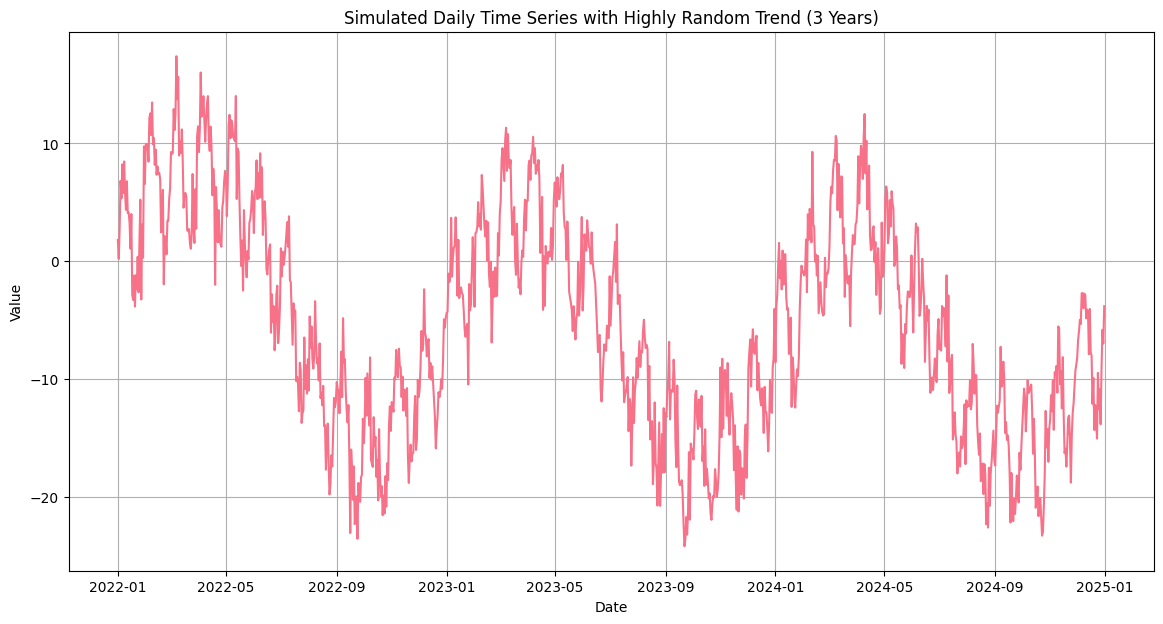

In [24]:
dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')

# Random walk without drift
trend_steps = np.random.normal(loc=[0], scale=0.2, size=len(dates))
trend = np.cumsum(trend_steps)

yearly_seasonality = 10 * np.sin(2 * np.pi * dates.dayofyear / 365)
monthly_seasonality = 5 * np.sin(2 * np.pi * dates.day / 30)
noise = np.random.normal(loc=0, scale=2, size=len(dates))

data = trend + yearly_seasonality + monthly_seasonality + noise

time_series = pd.DataFrame(data, index=dates)
time_series = time_series.reset_index()
time_series.columns = ['date', 'values']

plt.figure(figsize=(14, 7))
plt.plot(time_series.set_index('date')['values'])
plt.title('Simulated Daily Time Series with Highly Random Trend (3 Years)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [25]:
from time_series_data_nature_discovery import SeasonalityDetector

In [74]:
class TimeSeriesForcastor(SeasonalityDetector):
    def __init__(self, data, date_column, value_column):
        super().__init__(data, date_column, value_column)
        self.train_ts, self.val_ts, self.test_ts = self.__class__.split_time_series(self.ts)
        self.naive_pred, self.naive_rmse = self.__class__.naive_forecast(self.train_ts, self.test_ts)
    
    def plot_pred(self, method="naive"):
        
        if method.lower()=='naive':
            pred_index = self.naive_pred.index
            pred_values = self.naive_pred.values
            title = f'Naive Forecast vs. Actual Data (RMSE: {self.naive_rmse:.2f})'
        plt.figure(figsize=(10,6))
        # plot the original data in different colors
        # train data
        plt.plot(self.train_ts.index, 
                 self.train_ts.values, 
                 color = 'blue',
                 label = "Training Data"
                )
        # validation data
        plt.plot(self.val_ts.index, 
         self.val_ts.values, 
         color = 'orange',
         label = "Validation Data"
        )
        # test data
        plt.plot(self.test_ts.index, 
         self.test_ts.values, 
         color = 'green',
         label = "Test Data"
        )
        # pred data
        plt.plot(pred_index,
                 pred_values,
                 color = 'red',
                 label = 'Prediction'
        )
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel(self.value_column)
        plt.grid(True)
        plt.show()
        
    
    @staticmethod
    def naive_forecast(train, test):
        """Forecasts the next value as the last observed value."""
        # The last value of the training set is the first prediction
        last_value = train.iloc[-1]

        # All predictions for the test set are this same last value
        predictions = pd.Series(last_value, index=test.index)

        # Calculate error
        rmse = np.sqrt(mean_squared_error(test, predictions))
        return predictions, rmse
    
    @staticmethod
    def split_time_series(ts, train_pct=0.7, val_pct=0.15, test_pct=0.15):
        """
        Splits a time series chronologically into training, validation, and test sets.

        Args:
            ts (pd.Series): The time series data with a DatetimeIndex.
            train_pct (float): Percentage of data for the training set.
            val_pct (float): Percentage of data for the validation set.
            test_pct (float): Percentage of data for the test set.

        Returns:
            tuple: A tuple containing (train, val, test) pandas Series.
        """
        if round(train_pct + val_pct + test_pct, 10) != 1.0:
            raise ValueError("Percentages must sum to 1.0")

        n = len(ts)

        # Calculate split points
        train_end_idx = int(n * train_pct)
        val_end_idx = int(n * (train_pct + val_pct))

        # Split the data
        train_data = ts.iloc[:train_end_idx]
        val_data = ts.iloc[train_end_idx:val_end_idx]
        test_data = ts.iloc[val_end_idx:]

        print("--- Time Series Split ---")
        print(f"Training Set:   {len(train_data)} points ({train_data.index.min().date()} to {train_data.index.max().date()})")
        print(f"Validation Set: {len(val_data)} points ({val_data.index.min().date()} to {val_data.index.max().date()})")
        print(f"Test Set:       {len(test_data)} points ({test_data.index.min().date()} to {test_data.index.max().date()})")
        
        return train_data, val_data, test_data

In [75]:
time_series_forecastor = TimeSeriesForcastor(time_series, date_column = 'date', value_column = 'values')

--- Time Series Split ---
Training Set:   767 points (2022-01-01 to 2024-02-06)
Validation Set: 164 points (2024-02-07 to 2024-07-19)
Test Set:       165 points (2024-07-20 to 2024-12-31)


## Baseline model

Models used for a benchmark to compare with complicated models and see if they perform better than the benchmark or not.

### Naive forecasting model

Treating all forecast be the same value of the last t value. Upon this bench mark, it wont have a good accuray at all.

In [78]:
# data got assigned with last day value
(time_series_forecastor.naive_pred == time_series_forecastor.train_ts.iloc[-1]).all()

True

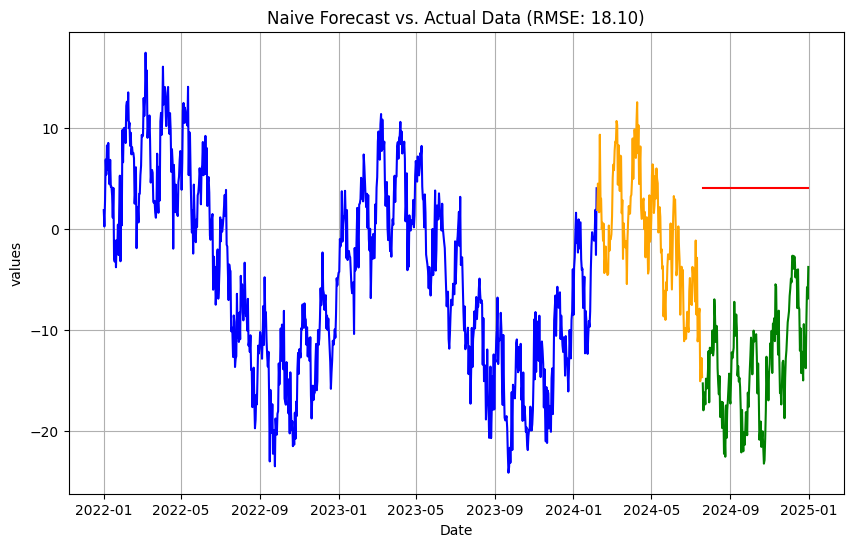

In [79]:
# plot the train, test and pred
time_series_forecastor.plot_pred()

In [80]:
# show the mean square error to check the accuracy
time_series_forecastor.naive_rmse

18.09603444517299